In [27]:
########################################## IMPORT LIBRARIES ##########################################

import pandas as pd
import numpy as np 
from collections import Counter
import time 
import itertools

import sys
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.stats import ks_2samp

from yellowbrick.cluster import KElbowVisualizer

########################################## MISC SETTINGS ##########################################
## Always show all columns in dataframe
pd.set_option('max_columns', None)

## Set rounding precision
pd.set_option('precision', 2)


########################################## SPOTIFY CREDENTIALS ##########################################
## Authentication info
CLIENT_ID = '58bf70b350d04276a69418b8d7dc0cb1'
CLIENT_SECRET = '42d7b4033b22494185af1cc33a069bcd'

## API Login
client_credentials_manager = SpotifyClientCredentials(client_id = CLIENT_ID, client_secret = CLIENT_SECRET)

## Spotify object to access API
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager) 


C:\Users\Matt\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## Keys / References

- 'info_...': dictionaries containing the info to be extracted


## Notes / Questions

(song features)
- Key: numeric representation of "pitch class" (C, C#/D, D, ...)
    - **concern/question:** Categorical variable; can it be left as numeric? Is there a set order/hierarchy of pitch, & does it match order of numeric representation (e.g. 0 (C) is in fact a lower pitch than 1 (C#/D) and 2 (D))?
        - If yes, can leave as a numeric column
        
        
    - Research findings (https://en.wikipedia.org/wiki/Pitch_class): "theorists typically represent pitch classes using numbers beginning from zero, with **each successively larger integer representing a pitch class that would be one semitone higher** than the preceding one"
        - natural order: can keep feature
        - higher the numeric representation = higher the pitch

___
___

# Custom Functions

Search for *single* [playlist] ID given a [partial] playlist name

In [9]:
# def find_id(info_dict, search_term):
    
#     """
#     Function to find ID for a given playlist from my library.  Can use partial term if don't know full name. Returns full name and ID
    
#     - info_dict:   name of dictionary containing info to extract
#     - search_term: name of [playlist] to search for
    
#     """

#     for i in np.arange(len(info_dict['items'])):

#         # if info_my_playlists['items'][i]['name'] == 'Bria':
#         if str(search_term) in info_dict['items'][i]['name']:

#             print(info_dict['items'][i]['name'], ':', info_dict['items'][i]['id'])

Show all playlists and corresponding IDs for a given username

In [10]:
def show_playlists(username):
    
    """
    
    """
    
    playlist_info =  sp.user_playlists(user = str(username))
    
    for i in np.arange(len(playlist_info['items'])):
        
        print(playlist_info['items'][i]['name'], ':  ', playlist_info['items'][i]['id'])
        

Function to create dataframe containing audio features for a given playlist

In [11]:
def create_playlist_df(playlist_id):
    
    """
    Create a dataframe containing the audio features of the songs in a given playlist
    """
    
    ## Get tracks from the given playlist (dictionary of tracks and corresponding track info)
    tracks = sp.user_playlist_tracks(user = 'spotify', playlist_id = playlist_id)
    
    ## Create list of the URIs for each track
    tracks_uri_list = [x['track']['uri'] for x in tracks['items']]
    
    
    ## Extract track features from the dictionary
    features = []
    for i in tracks_uri_list:
        features = features + sp.audio_features(i)

    ## Add song and artist name to track dictionaries
    for i in np.arange(len(features)):
        ## Song name
        features[i]['Song Title'] = tracks['items'][i]['track']['name']

        ## Main Artist name
        features[i]['Main Artist'] = tracks['items'][i]['track']['artists'][0]['name']
        
        
    ## Create feature dataframe
    # cols_to_drop = ['analysis_url', 'key', 'time_signature', 'track_href', 'type', 'uri', 'mode', 'duration_ms']
    cols_to_drop = ['analysis_url',  'track_href', 'uri',  'duration_ms', 'type', 'mode']

    features_df = pd.DataFrame(features).drop(cols_to_drop, axis=1)

    ## Rearrange order of columns
    column_order = ['id', 'Song Title', 'Main Artist', 'danceability', 'energy', 'speechiness', 'acousticness', 
                    'instrumentalness',  'loudness', 'time_signature', 'key']
    
    return features_df.reindex(columns = column_order)

In [12]:
def cluster_distrib(df, cluster_col):
    
    '''
    
    '''
    
    df_clusters = pd.DataFrame(df.groupby(cluster_col)['id'].nunique())
    
    df_clusters['%'] = df_clusters['id'] / df_clusters['id'].sum()
    
    return df_clusters

In [13]:
def ks_test_results(df, feature):
    
    """
    Run Kolmogorov-Smirnov (KS) Test on all combinations of clusters for a given feature.  Populate results into a dataframe.
    P-values <= 0.05 will be formated in green color, representing difference for this feature is statistically significant
    
    df: main dataframe, containing feature data & cluster assignments
    feature: name of feature to compare between distributions
    """
    
    ## Create a list of all possible combinations of cluster names to compare (wihtout repetition)
    combo_list = list(itertools.combinations(df['Cluster'].unique(), r = 2))

    ## Create shell of dataframe to hold results
    df_results = pd.DataFrame(index = combo_list, columns = ['Statistic', 'P-Value'])


    ## for each possible combination of clusters to compare
    for combo in combo_list:

        ## Run KS Test; store results to be input into dataframe
        ks_result = ks_2samp(df[df['Cluster'] == combo[0]][feature], df_final[df_final['Cluster'] == combo[1]][feature])

        ## populate row corresponding with given combo with the given results
        df_results.loc[df_results.index == combo, 'Statistic'] = ks_result[0]
        df_results.loc[df_results.index == combo, 'P-Value'] = ks_result[1]

    
    ## Define function to identify p-values < 0.05
    def highlight_pval(value):
        color = 'green' if value <= 0.05 else 'black'
        return 'color: {}'.format(color)

    
    print(feature.upper())
    return df_results.style.applymap(highlight_pval)    


___
___

# <font color = green>  Playlist Analysis - Clustering

### (1) Create dataframe with features of my saved songs
Spotipy only allows pulling 100 songs at a time.  I created a playlist for each 100 songs; each will be made into seperate dataframes, then combined into one.

- Guide to song features:
 https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/

In [14]:
show_playlists('mvashaw11')

My Saved Songs - 3 :   40khHexSC2uI4u4F9SkQc4
My Saved Songs - 2 :   0ZCx5hTF6cMJMDtFNze1L4
My Saved Songs - 1 :   2Or8M6td9mdphzY1NpX8I3
This Is: Kendrick Lamar, J. Cole, Drake, Anderson Paak, Jay-Z :   1mibm16JKeyGz8pFgRSnXf
Bria :   3TJrcccNI7Msecn5Cz2Woy
Leuven :   4lTaeTdDPpKSXNAcwXhOu9
WFH :   15GvWlhYGJNdWELh2OtuHv
Alternative :   3O4Vv9SRVZi2pnScHVphsF
Oldies :   2vndQZtaOsKH72Eu70mJ7g
Oldies :   4t1VyaYRysk6fig8CppYjn
My Shazam Tracks :   6ijTguwsiFRRpC7MknrBVJ
Christmas :   070lD2MKqfnqjQ5tPy9cbu
Mellow :   3KmFod6yrYZQSsBJWKBkZf
Latin :   33KDiRLgqOeEW5hwOZCrbo
Gym :   2YYLtyXcxTbWcCptJFYqQR
Old(ish) School :   40d3t7YXPxBD3hTKjuYfEf
Liked from Radio :   2OpcXGct2lK13h08OT0S8X


In [15]:
start_time = time.time()

## Create dataframes for each of the subplaylist
df_savedsongs_1 = create_playlist_df('40khHexSC2uI4u4F9SkQc4')
df_savedsongs_2 = create_playlist_df('0ZCx5hTF6cMJMDtFNze1L4')
df_savedsongs_3 = create_playlist_df('2Or8M6td9mdphzY1NpX8I3')

## Combine the individual playlists into one
df_mysongs = pd.concat([df_savedsongs_1, df_savedsongs_2, df_savedsongs_3], ignore_index = True)

## Show code run-time
print("--- %s minutes ---" % ((time.time() - start_time)/60))

## Print size of dataframe
print(df_mysongs.shape)

df_mysongs.head()

--- 0.4369811177253723 minutes ---
(297, 11)


,id,Song Title,Main Artist,danceability,energy,speechiness,acousticness,instrumentalness,loudness,time_signature,key
0,1uDrIgjVtFsrrWWctCxoBL,Grown Up,Danny Brown,0.64,0.77,0.26,1.32e-01,0.00e+00,-6.45,4,11
1,7x6hO9VMAee9x1iWaeNkL6,To Zion (feat. Carlos Santana),Ms. Lauryn Hill,0.41,0.60,0.50,1.27e-01,0.00e+00,-10.71,4,7
2,3vv9phIu6Y1vX3jcqaGz5Z,Roses (feat. ROZES),The Chainsmokers,0.71,0.80,0.06,4.35e-02,3.77e-03,-7.05,4,4
3,0K7XjmTNFwQ2qwHn4MjlDx,No Better Love,Young Gunz,0.67,0.90,0.26,1.81e-01,0.00e+00,-3.05,4,8
4,0WLhJ2NBuZHuoHY8pLVHJ0,Contact (feat. Tyga),Wiz Khalifa,0.84,0.69,0.04,1.81e-03,0.00e+00,-5.40,4,8


# <font color = green> Clustering

### (1) Data Prep & Exploration

1a) Isolate features
- For the clustering, we can only use the numeric features. Therefore, I drop the title and artist; The song id will be used as the index for each dataframe for easy matching after the clustering analysis

In [16]:
## Separate the features
df_mysongs_features = pd.DataFrame(df_mysongs.drop(['Main Artist', 'Song Title', 'id'], axis = 1))

df_mysongs_features.head()

,danceability,energy,speechiness,acousticness,instrumentalness,loudness,time_signature,key
0,0.64,0.77,0.26,1.32e-01,0.00e+00,-6.45,4,11
1,0.41,0.60,0.50,1.27e-01,0.00e+00,-10.71,4,7
2,0.71,0.80,0.06,4.35e-02,3.77e-03,-7.05,4,4
3,0.67,0.90,0.26,1.81e-01,0.00e+00,-3.05,4,8
4,0.84,0.69,0.04,1.81e-03,0.00e+00,-5.40,4,8


In [17]:
# ## Save title and artist for joining later
# df_mysongs_titles = pd.DataFrame(df_mysongs[['Song Title', 'Main Artist']])

# ## Save title and artist for joining later
# df_mysongs_titles = pd.DataFrame(df_mysongs[['Song Title', 'Main Artist']])
# # df_mysongs_titles.index = df_mysongs['id']

# df_mysongs_titles.head()

1b) Exploration the features: What does the distribution of these features look like across my saved songs?
- Loud; High energy; danceable
- Low levels of instrumental & speech
- Predominately 4 beats per bar (Time Signature)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000027537A8C048>,
      dtype=object)

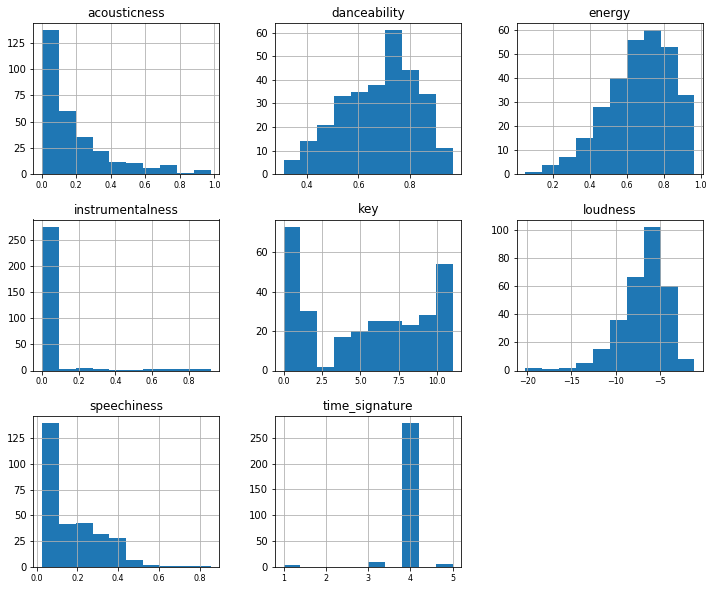

In [21]:
df_mysongs_features.hist(xlabelsize=8, figsize=(12,10))

Feature Summary:
- **Acousticness**: measure of confidence if track is acoustic (1 = confident track is acoustic)


- **Danceability**: based on combination of musical elements like tempo, rhythm stability, beat strength, and regularity


- **Energy**: Perceptual measure of instensity & activity; based on dynamic range, perceived loudness, timbre, onset rate, entropy
    - higher energy = fast, loud, noisy

- **Instrumentalness**:  Greater than .5 represents mostly instrumental tracks
    - "ooh", "aah" sounds treated as instrumental; rap & spoken word treated as vocal

- **Key**: represents pitch; higher the value = higher the pitch

- **Loudness**: Loudness in decibels, averaged across a given track

- **Speechiness**: Presence of spoken words in the track.  
    - '< 0.33      = likely music & non-speech tracks
    - 0.33 - 0.66 = contain both music & speech
    - '> 0.66      = track is probably entirely spoken word

- **Time Signature**: How many beats per bar

1c) Normalize the features
- Clustering utilizes distance measures, which requires all features to be on the same scale; if any feature(s) are on a larger scale than the others, it can significantly distort the distance metrics. Therefore, all the features need to be adjusted to the same scale. 
- As seen below, most features range between 0 - 1, so I will normalize the features that are not (Key, Loudness, and Time Signature) to put on a scale between 0-1

In [22]:
df_mysongs_features.describe()

,danceability,energy,speechiness,acousticness,instrumentalness,loudness,time_signature,key
count,297.00,297.00,297.00,2.97e+02,2.97e+02,297.00,297.00,297.00
mean,0.68,0.67,0.18,1.88e-01,3.52e-02,-6.94,3.96,5.44
std,0.14,0.17,0.14,2.08e-01,1.36e-01,2.73,0.37,3.71
min,0.31,0.05,0.03,5.63e-05,0.00e+00,-20.19,1.00,0.00
25%,0.57,0.57,0.06,3.34e-02,0.00e+00,-8.13,4.00,2.00
50%,0.70,0.69,0.13,1.15e-01,4.38e-06,-6.51,4.00,6.00
75%,0.79,0.80,0.27,2.76e-01,8.68e-04,-5.13,4.00,9.00
max,0.97,0.97,0.85,9.81e-01,9.19e-01,-1.15,5.00,11.00


In [64]:
from sklearn import preprocessing

## Make list of columns to scale
columns_to_scale = ['loudness', 'time_signature', 'key']

## Create an instance of the scaler
scaler = preprocessing.MinMaxScaler()

## Create new dataframe with scaled features
df_scaled_features = pd.DataFrame(scaler.fit_transform(df_mysongs_features[columns_to_scale]), 
                                  columns = columns_to_scale, index = df_mysongs_features.index)

## Combine with other features; drop original (unscaled) columns
df_scaled_features = df_mysongs_features.drop(columns_to_scale, axis = 1).join(df_scaled_features)

df_scaled_features.head()

,danceability,energy,speechiness,acousticness,instrumentalness,loudness,time_signature,key
0,0.64,0.77,0.26,1.32e-01,0.00e+00,0.72,0.75,1.00
1,0.41,0.60,0.50,1.27e-01,0.00e+00,0.50,0.75,0.64
2,0.71,0.80,0.06,4.35e-02,3.77e-03,0.69,0.75,0.36
3,0.67,0.90,0.26,1.81e-01,0.00e+00,0.90,0.75,0.73
4,0.84,0.69,0.04,1.81e-03,0.00e+00,0.78,0.75,0.73


In [65]:
df_scaled_features.describe()

,danceability,energy,speechiness,acousticness,instrumentalness,loudness,time_signature,key
count,297.00,297.00,297.00,2.97e+02,2.97e+02,297.00,297.00,297.00
mean,0.68,0.67,0.18,1.88e-01,3.52e-02,0.70,0.74,0.49
std,0.14,0.17,0.14,2.08e-01,1.36e-01,0.14,0.09,0.34
min,0.31,0.05,0.03,5.63e-05,0.00e+00,0.00,0.00,0.00
25%,0.57,0.57,0.06,3.34e-02,0.00e+00,0.63,0.75,0.18
50%,0.70,0.69,0.13,1.15e-01,4.38e-06,0.72,0.75,0.55
75%,0.79,0.80,0.27,2.76e-01,8.68e-04,0.79,0.75,0.82
max,0.97,0.97,0.85,9.81e-01,9.19e-01,1.00,1.00,1.00


### (2) Determine Cluster size

**v1**

Text(0.5, 0, 'Number of Clusters')

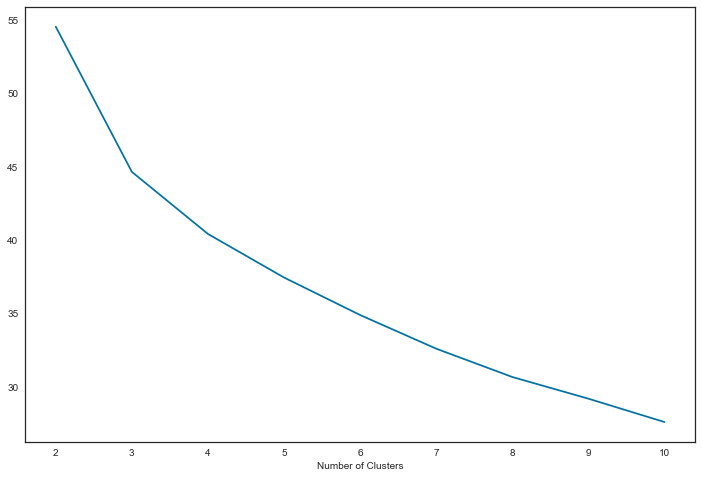

In [66]:
## Set size of plot
plt.figure(figsize = (12, 8))
sns.set_style('white')


## Declare MIN number of clusters to test
min_k = 2

## Declare MAX number of clusters to test
max_k = 10

## Determining the cluster size
score_list = []
for i in np.arange(min_k, max_k+1):
    ## Fit a clustering model to the scaled data.  Iterate through various number of clusters
    kmeans_model = KMeans(n_clusters=i, random_state=21).fit(df_scaled_features)
    
    ## Create predictions using model
    preds = kmeans_model.predict(df_scaled_features)
    
    ## Add model k's score to list
    score_list.append(kmeans_model.inertia_)

## Plot the results
sns.lineplot(np.arange(min_k, max_k + 1), score_list)
plt.xlabel('Number of Clusters', size = 10)

For added reference, we can review the "scores".  The point value of 'k' after which the score starts to decrease by much less represents the optimal value of 'k'

In [67]:
print(score_list, '\n')
for i in np.arange(1, len(score_list) + 1):
    
    if i != len(score_list):
    
        #print(i, 'to', i+1, ":   ", round(score_list[i-1] - score_list[i], 1))
        print(i, ":   ", round(score_list[i-1] - score_list[i], 1))
    

[54.5646515389038, 44.662831689091064, 40.427725015004185, 37.45571461802132, 34.8982892527916, 32.60148165685261, 30.670806236983125, 29.19141914406992, 27.59935711195951] 

1 :    9.9
2 :    4.2
3 :    3.0
4 :    2.6
5 :    2.3
6 :    1.9
7 :    1.5
8 :    1.6


v2 - **Yellowbrick Method**

The KElbowVisualizer implements the “elbow” method to help select the optimal number of clusters by fitting the clustering model with a range of values for K (the number of clusters). If the line chart resembles an arm, then the “elbow” (the point of inflection on the curve) is a good indication that the underlying model fits best at that point. In the visual, the “elbow” will be indicated with a dashed line.


Distortion - this method uses distortion as the scoring metric.  Distortion "computes the sum of squared distances from each point to its assigned center"

References:
- https://medium.com/data-science-community-srm/machine-learning-visualizations-with-yellowbrick-3c533955b1b3
- https://www.scikit-yb.org/en/latest/api/cluster/elbow.html

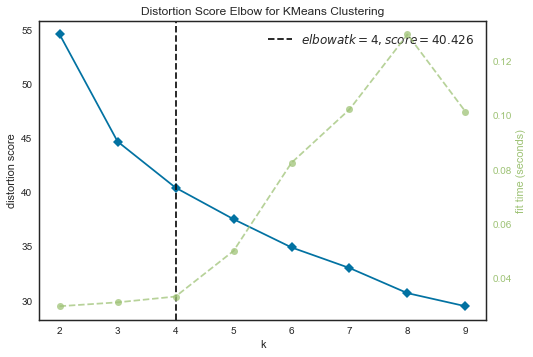

In [68]:
## Declare MIN number of clusters to test
min_k = 2

## Declare MAX number of clusters to test
max_k = 10

## Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k = (min_k, max_k))

visualizer.fit(df_scaled_features)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

<font color = grey> **(make this a custom function)**

### (3) Fit Final Model
Optimal number of clusters = **4**

Final cluster assignments will be made using a model fit using k = 4

In [69]:
k = 4

## Fit a clustering model to the scaled data.  Iterate through various number of clusters
kmeans_model = KMeans(n_clusters= k, random_state=21).fit(df_scaled_features)

## Create predictions using model
preds = kmeans_model.predict(df_scaled_features)
preds = pd.DataFrame(preds, columns = ['Cluster'])

## Add predictions back to original data
df_final = pd.concat([df_mysongs, preds], axis = 1)

print(cluster_distrib(df_final, 'Cluster'))

df_final.head()

          id     %
Cluster           
0         73  0.25
1         94  0.32
2         27  0.09
3        103  0.35


,id,Song Title,Main Artist,danceability,energy,speechiness,acousticness,instrumentalness,loudness,time_signature,key,Cluster
0,1uDrIgjVtFsrrWWctCxoBL,Grown Up,Danny Brown,0.64,0.77,0.26,1.32e-01,0.00e+00,-6.45,4,11,1
1,7x6hO9VMAee9x1iWaeNkL6,To Zion (feat. Carlos Santana),Ms. Lauryn Hill,0.41,0.60,0.50,1.27e-01,0.00e+00,-10.71,4,7,1
2,3vv9phIu6Y1vX3jcqaGz5Z,Roses (feat. ROZES),The Chainsmokers,0.71,0.80,0.06,4.35e-02,3.77e-03,-7.05,4,4,0
3,0K7XjmTNFwQ2qwHn4MjlDx,No Better Love,Young Gunz,0.67,0.90,0.26,1.81e-01,0.00e+00,-3.05,4,8,1
4,0WLhJ2NBuZHuoHY8pLVHJ0,Contact (feat. Tyga),Wiz Khalifa,0.84,0.69,0.04,1.81e-03,0.00e+00,-5.40,4,8,1


### (4) Explore Clusters
Review how many songs per cluster, and how the distributions of each feature vary by cluster.

          id     %
Cluster           
0         73  0.25
1         94  0.32
2         27  0.09
3        103  0.35


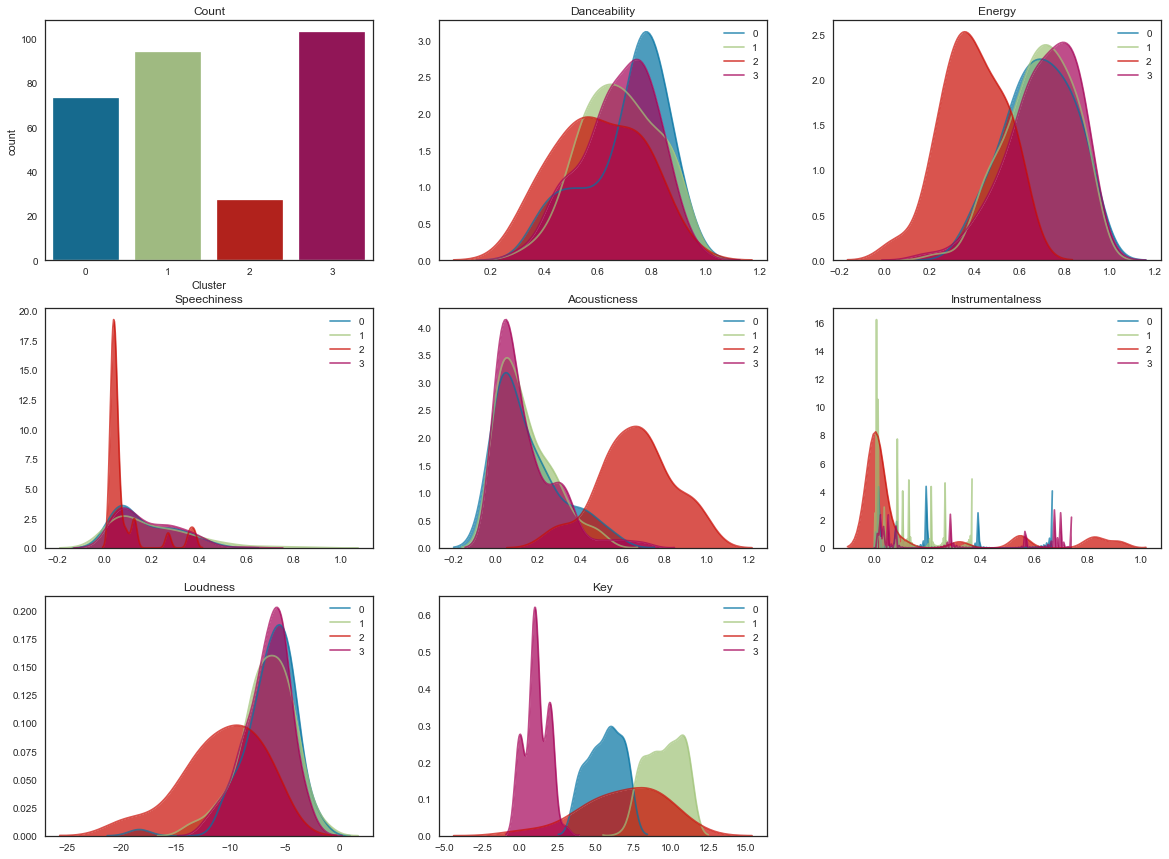

In [70]:
## Set layout of subplots
fig, ax = plt.subplots(3, 3, figsize=(20, 15))

## How many songs per cluster
print(cluster_distrib(df_final, 'Cluster'))
ax[0,0].title.set_text('Count')
sns.countplot(x = df_final['Cluster'], ax = ax[0,0])

## Plot the distributions of the features
ax[0,1].title.set_text('Danceability')
for cluster in np.arange(0,k+1):
    sns.kdeplot(df_final[df_final['Cluster'] == cluster]['danceability'], label = cluster, shade = True, alpha = .7, ax = ax[0,1])

ax[0,2].title.set_text('Energy')
for cluster in np.arange(0,k+1):
    sns.kdeplot(df_final[df_final['Cluster'] == cluster]['energy'], label = cluster, shade = True, alpha = .7, ax = ax[0,2])

ax[1,0].title.set_text('Speechiness')
for cluster in np.arange(0,k+1):
    sns.kdeplot(df_final[df_final['Cluster'] == cluster]['speechiness'], label = cluster, shade = True, alpha = .7, ax = ax[1, 0])

ax[1,1].title.set_text('Acousticness')
for cluster in np.arange(0,k+1):
    sns.kdeplot(df_final[df_final['Cluster'] == cluster]['acousticness'], label = cluster, shade = True, alpha = .7, ax = ax[1,1])

ax[1,2].title.set_text('Instrumentalness')
for cluster in np.arange(0,k+1):
    sns.kdeplot(df_final[df_final['Cluster'] == cluster]['instrumentalness'], label = cluster, shade = True, alpha = .7, ax = ax[1,2])

ax[2,0].title.set_text('Loudness')
for cluster in np.arange(0,k+1):
    sns.kdeplot(df_final[df_final['Cluster'] == cluster]['loudness'], label = cluster, shade = True, alpha = .7, ax = ax[2,0])
    
ax[2,1].title.set_text('Key')
for cluster in np.arange(0,k+1):
    sns.kdeplot(df_final[df_final['Cluster'] == cluster]['key'], label = cluster, shade = True, alpha = .7, ax = ax[2,1])

## Remove extra subplot
fig.delaxes(ax[2,2])

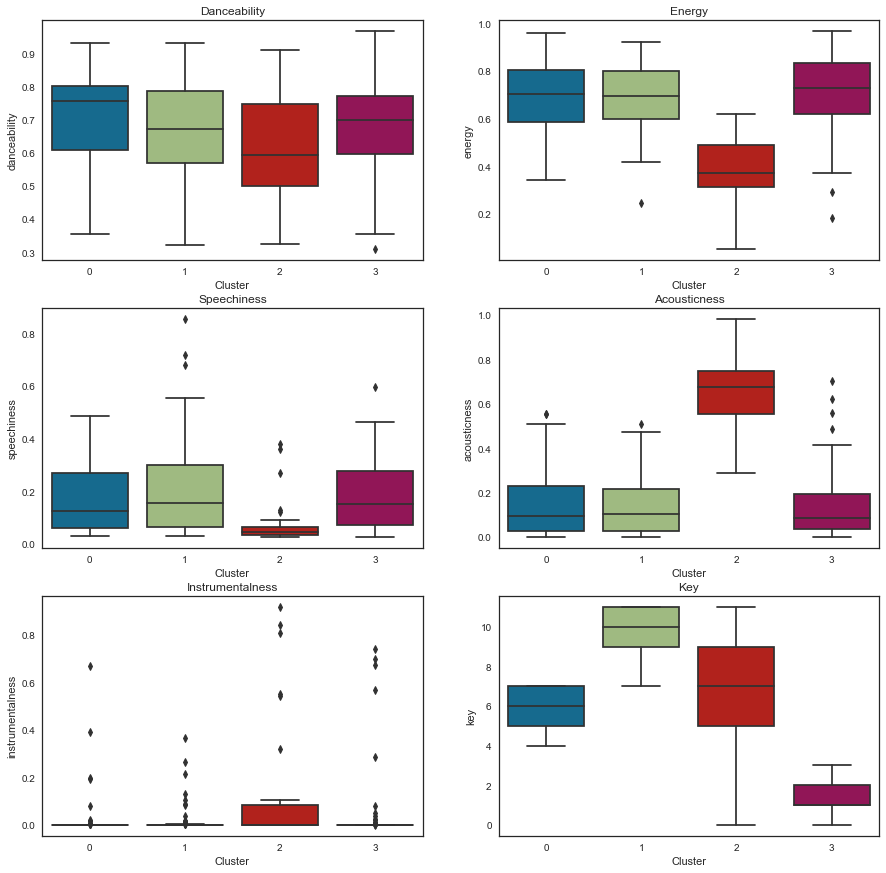

In [71]:
## Set layout of subplots
fig, ax = plt.subplots(3, 2, figsize=(15, 15))


ax[0,0].title.set_text('Danceability')
sns.boxplot(df_final['Cluster'], df_final['danceability'], ax = ax[0,0])

ax[0,1].title.set_text('Energy')
sns.boxplot(df_final['Cluster'], df_final['energy'], ax = ax[0,1])

ax[1,0].title.set_text('Speechiness')
sns.boxplot(df_final['Cluster'], df_final['speechiness'], ax = ax[1,0])

ax[1,1].title.set_text('Acousticness')
sns.boxplot(df_final['Cluster'], df_final['acousticness'], ax = ax[1,1])

ax[2,0].title.set_text('Instrumentalness')
sns.boxplot(df_final['Cluster'], df_final['instrumentalness'], ax = ax[2,0])

ax[2,1].title.set_text('Key')
sns.boxplot(df_final['Cluster'], df_final['key'], ax = ax[2,1])


Review which songs are in each cluster

In [72]:
cluster_0 = [r['Song Title'] + " | " + r['Main Artist'] for i, r in df_final[df_final['Cluster'] == 0].iterrows()]
cluster_1 = [r['Song Title'] + " | " + r['Main Artist'] for i, r in df_final[df_final['Cluster'] == 1].iterrows()]
cluster_2 = [r['Song Title'] + " | " + r['Main Artist'] for i, r in df_final[df_final['Cluster'] == 2].iterrows()]
cluster_3 = [r['Song Title'] + " | " + r['Main Artist'] for i, r in df_final[df_final['Cluster'] == 3].iterrows()]

pd.set_option("max_rows", None)
df_cluster_results = pd.concat([pd.DataFrame(cluster_0), pd.DataFrame(cluster_1), pd.DataFrame(cluster_2),
                                pd.DataFrame(cluster_3),], ignore_index = True, axis = 1)

## Fill extra rows in shorter columns with empty space
df_cluster_results.fillna('', inplace = True)

df_cluster_results

,0,1,2,3
0,Roses (feat. ROZES) | The Chainsmokers,Grown Up | Danny Brown,Tonight I'll Be Staying Here with You | Liam B...,Whoa | Snoh Aalegra
1,Anybody | Burna Boy,To Zion (feat. Carlos Santana) | Ms. Lauryn Hill,Pretty Little Fears (feat. J. Cole) | 6LACK,Valerie (feat. Amy Winehouse) - Version Revisi...
2,W (feat. Gunna) | Koffee,No Better Love | Young Gunz,My God Has A Telephone | The Flying Stars Of B...,Blood Diamonds | The Game
3,Lucifer | JAY-Z,Contact (feat. Tyga) | Wiz Khalifa,Wild | Marian Hill,"Down Bad (feat. JID, Bas, J. Cole, EARTHGANG &..."
4,Bad Bad News | Leon Bridges,Higher Love | Kygo,Apparently | J. Cole,You Worry Me | Nathaniel Rateliff & The Night ...
5,I Just Wanna Love U (Give It 2 Me) | JAY-Z,Encore | JAY-Z,Latch - Acoustic | Sam Smith,Can't Take My Eyes Off of You - (I Love You Ba...
6,Shine | Lil Wayne,Having A Party - Live | Nathaniel Rateliff & T...,Angel from Montgomery - Live | Susan Tedeschi,Boasty (feat. Idris Elba) | Wiley
7,Ballin' (with Roddy Ricch) | Mustard,What We Do | Freeway,Sunset Lover | Petit Biscuit,Xxplosive | Dr. Dre
8,Otis | JAY-Z,RITMO (Bad Boys For Life) | Black Eyed Peas,Rivers Of Babylon - Acoustic Version | Sublime,On Me (feat. Cardi B) | Meek Mill
9,BROWN SKIN GIRL | Blue Ivy,The Box | Roddy Ricch,Blessings (feat. Jamila Woods) | Chance the Ra...,Don't Owe You a Thang | Gary Clark Jr.


Observations:
- With this method - for both 3 and 4 clusters - approximately 71% of the songs end up in 1 cluster, and another 23-24% in a second.  This is provides very little distinction between clusters. 


- One interpretation: **I do acutally have a rather concentrated taste in music**

___
## PCA

In [80]:
## We'll use 2 components for plotting purposes (x, y axis)
pca = PCA(n_components = 2)

## Apply PC instances to the scaled features.  Create a dataframe 
# df_princ_comp = pd.DataFrame(pca.fit_transform(df_scaled_features), columns = ['PC 1', 'PC 2', 'PC 3'])
df_princ_comp = pd.DataFrame(pca.fit_transform(df_scaled_features), columns = ['PC 1', 'PC 2'])

## Add Cluster labels back in 
df_princ_comp = df_princ_comp.join(df_final['Cluster'])

## Display the amount of varia
print('PC 1:', round(pca.explained_variance_ratio_[0], 3), '| PC 2:', round(pca.explained_variance_ratio_[1], 3))
print(round(pca.explained_variance_ratio_.sum(), 3))

df_princ_comp.head()

PC 1: 0.42 | PC 2: 0.221
0.641


,PC 1,PC 2,Cluster
0,0.48,-0.20,1
1,0.15,0.04,1
2,-0.16,-0.15,0
3,0.19,-0.26,1
4,0.19,-0.23,1


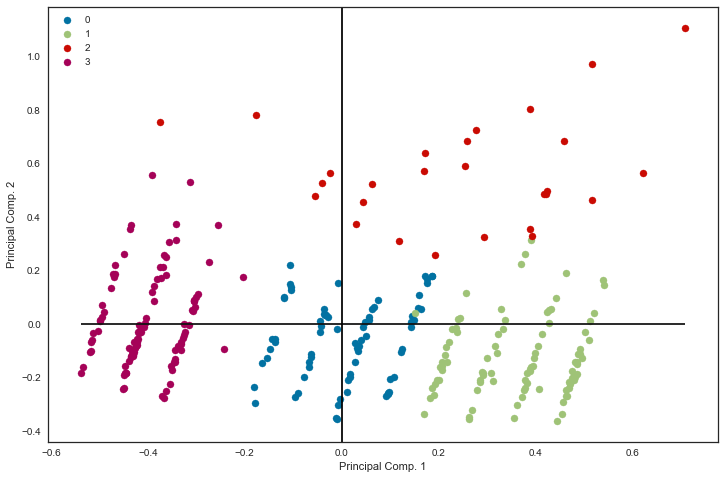

In [81]:
## Set size of plot
plt.figure(figsize = (12, 8))


# colors = ['r', 'g', 'b']
# for target, color in zip(targets,colors):
for cluster in np.arange(0,k):
    
    plt.scatter(df_princ_comp[df_princ_comp['Cluster'] == cluster]['PC 1'],
               df_princ_comp[df_princ_comp['Cluster'] == cluster]['PC 2'], s = 50, label = cluster)

## Plot lines at x = 0 & y = 0 to help distinguish between PCs    
plt.axvline(x = 0, color = 'black')
plt.hlines(y=0, xmin = df_princ_comp['PC 1'].min(), xmax = df_princ_comp['PC 1'].max())

plt.xlabel('Principal Comp. 1')
plt.ylabel('Principal Comp. 2')
plt.legend()
# ax.grid()

C:\Users\Matt\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


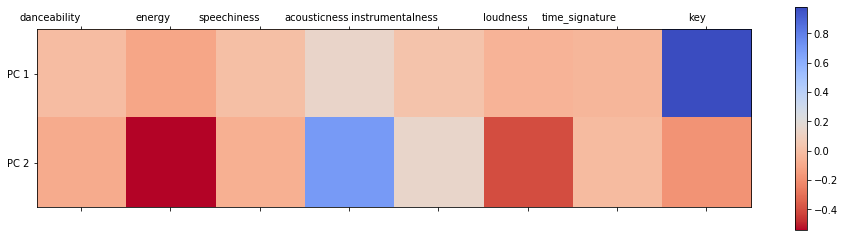

In [98]:
## Horizontal
plt.matshow(pca.components_,cmap='coolwarm_r')
plt.xticks(range(len(df_scaled_features.columns)), df_scaled_features.columns, ha='right')

plt.yticks([0,1],['PC 1','PC 2'],fontsize=10)

plt.colorbar()
plt.tight_layout()


# ## Vertical
# plt.matshow(pca.components_.T,cmap='coolwarm_r')
# plt.yticks(range(len(df_scaled_features.columns)), df_scaled_features.columns, ha='right')

# plt.xticks([0,1],['PC 1','PC 2'],fontsize=10)

# plt.colorbar()
# plt.tight_layout()

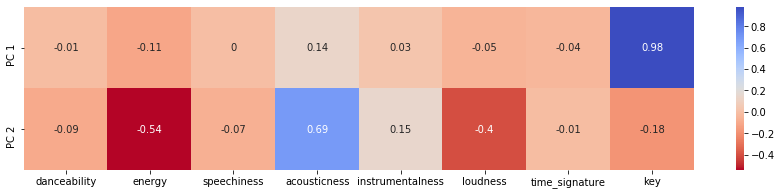

In [262]:
#### Use heatmap with values in cellls

## Set size of plot
plt.figure(figsize = (15, 3))

pca_comp_vals = pd.DataFrame(pca.components_.T, columns = ['PC 1', 'PC 2'], index = df_scaled_features.columns)

sns.heatmap(round(pca_comp_vals, 2).T, annot=True, cmap='coolwarm_r')

___
# Hypothesis Testing: Kolmogorov-Smirnov (KS)  Test
Test for statistical significance in difference in features between clusters
- Null hypo = two distributions are identical

- Goal: see if there is actually any difference in a given feature between clusters

- Interpretting:
    - p-value: if below given threshold (.05), probable that the two distributions are different (i.e. reject the null)
    - "If the K-S statistic is small or the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples are the same" (scipy doc)
        

In [200]:
ks_test_results(df_final, 'danceability')

DANCEABILITY


,Statistic,P-Value
"(1, 0)",0.23,0.02
"(1, 3)",0.09,0.79
"(1, 2)",0.25,0.11
"(0, 3)",0.20,0.05
"(0, 2)",0.35,0.01
"(3, 2)",0.31,0.02


In [201]:
ks_test_results(df_final, 'energy')

ENERGY


,Statistic,P-Value
"(1, 0)",0.07,0.97
"(1, 3)",0.11,0.54
"(1, 2)",0.74,0.00
"(0, 3)",0.14,0.33
"(0, 2)",0.69,0.00
"(3, 2)",0.76,0.00


In [202]:
ks_test_results(df_final, 'speechiness')

SPEECHINESS


,Statistic,P-Value
"(1, 0)",0.11,0.65
"(1, 3)",0.10,0.67
"(1, 2)",0.52,0.00
"(0, 3)",0.10,0.68
"(0, 2)",0.52,0.00
"(3, 2)",0.60,0.00


In [203]:
ks_test_results(df_final, 'acousticness')

ACOUSTICNESS


,Statistic,P-Value
"(1, 0)",0.10,0.78
"(1, 3)",0.11,0.59
"(1, 2)",0.89,0.00
"(0, 3)",0.10,0.71
"(0, 2)",0.88,0.00
"(3, 2)",0.89,0.00


In [204]:
ks_test_results(df_final, 'instrumentalness')

INSTRUMENTALNESS


,Statistic,P-Value
"(1, 0)",0.07,0.98
"(1, 3)",0.10,0.63
"(1, 2)",0.29,0.05
"(0, 3)",0.06,0.99
"(0, 2)",0.32,0.03
"(3, 2)",0.32,0.02


In [205]:
ks_test_results(df_final, 'loudness')

LOUDNESS


,Statistic,P-Value
"(1, 0)",0.14,0.39
"(1, 3)",0.09,0.75
"(1, 2)",0.56,0.00
"(0, 3)",0.14,0.33
"(0, 2)",0.62,0.00
"(3, 2)",0.56,0.00


In [206]:
ks_test_results(df_final, 'time_signature')

TIME_SIGNATURE


,Statistic,P-Value
"(1, 0)",0.01,1.00
"(1, 3)",0.04,1.00
"(1, 2)",0.11,0.95
"(0, 3)",0.03,1.00
"(0, 2)",0.11,0.95
"(3, 2)",0.14,0.75


In [242]:
ks_test_results(df_final, 'key')

KEY


,Statistic,P-Value
"(1, 0)",0.99,0.00
"(1, 3)",1.00,0.00
"(1, 2)",0.54,0.00
"(0, 3)",1.00,0.00
"(0, 2)",0.44,0.00
"(3, 2)",0.93,0.00


# -------------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------

## Check standard scaler

In [48]:
from sklearn.preprocessing import StandardScaler

## Create an instance of the scaler
scaler = StandardScaler()

## Fit and transform features.  Make into a dataframe 
df_scaled_features = pd.DataFrame(scaler.fit_transform(df_mysongs_features), columns = df_mysongs_features.columns)

df_scaled_features.head()

,danceability,energy,speechiness,acousticness,instrumentalness,loudness,time_signature,key
0,-0.31,0.57,0.59,-0.27,-0.26,0.18,0.11,1.50
1,-1.86,-0.39,2.30,-0.29,-0.26,-1.39,0.11,0.42
2,0.23,0.78,-0.84,-0.70,-0.23,-0.04,0.11,-0.39
3,-0.04,1.33,0.58,-0.03,-0.26,1.42,0.11,0.69
4,1.11,0.14,-0.99,-0.90,-0.26,0.56,0.11,0.69


### (2) Determine Cluster size

Text(0.5, 0, 'Number of Clusters')

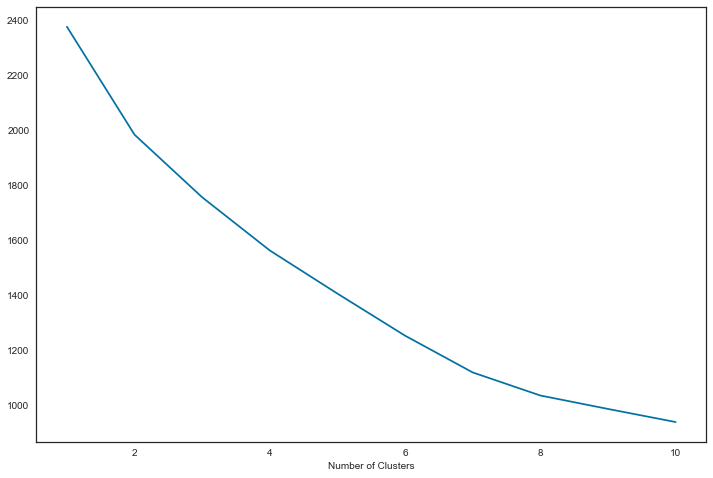

In [49]:
## Set size of plot
plt.figure(figsize = (12, 8))

## Declare number of clusters to test
k = 10

## Determining the cluster size
score_list = []
for i in np.arange(1, k+1):
    ## Fit a clustering model to the scaled data.  Iterate through various number of clusters
    kmeans_model = KMeans(n_clusters=i, random_state=21).fit(df_scaled_features)
    
    ## Create predictions using model
    preds = kmeans_model.predict(df_scaled_features)
    
    ## Add model k's score to list
    score_list.append(kmeans_model.inertia_)

## Plot the results
sns.lineplot(np.arange(1, k + 1), score_list)
plt.xlabel('Number of Clusters', size = 10)

C:\Users\Matt\anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\Matt\anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


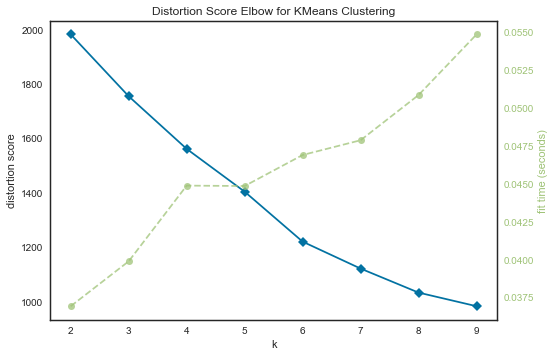

In [54]:
## Declare MIN number of clusters to test
min_k = 2

## Declare MAX number of clusters to test
max_k = 10

## Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k = (min_k, max_k))

visualizer.fit(df_scaled_features)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

### (3) Fit Final Model


In [55]:
k = 5

## Fit a clustering model to the scaled data.  Iterate through various number of clusters
kmeans_model = KMeans(n_clusters= k, random_state=21).fit(df_scaled_features)

## Create predictions using model
preds = kmeans_model.predict(df_scaled_features)
preds = pd.DataFrame(preds, columns = ['Cluster'])

## Add predictions back to original data
df_final = pd.concat([df_mysongs, preds], axis = 1)

df_final.head()

,id,Song Title,Main Artist,danceability,energy,speechiness,acousticness,instrumentalness,loudness,time_signature,key,Cluster
0,1uDrIgjVtFsrrWWctCxoBL,Grown Up,Danny Brown,0.64,0.77,0.26,1.32e-01,0.00e+00,-6.45,4,11,1
1,7x6hO9VMAee9x1iWaeNkL6,To Zion (feat. Carlos Santana),Ms. Lauryn Hill,0.41,0.60,0.50,1.27e-01,0.00e+00,-10.71,4,7,1
2,3vv9phIu6Y1vX3jcqaGz5Z,Roses (feat. ROZES),The Chainsmokers,0.71,0.80,0.06,4.35e-02,3.77e-03,-7.05,4,4,4
3,0K7XjmTNFwQ2qwHn4MjlDx,No Better Love,Young Gunz,0.67,0.90,0.26,1.81e-01,0.00e+00,-3.05,4,8,1
4,0WLhJ2NBuZHuoHY8pLVHJ0,Contact (feat. Tyga),Wiz Khalifa,0.84,0.69,0.04,1.81e-03,0.00e+00,-5.40,4,8,0


         id     %
Cluster          
0        83  0.28
1        69  0.23
2        11  0.04
3        35  0.12
4        99  0.33


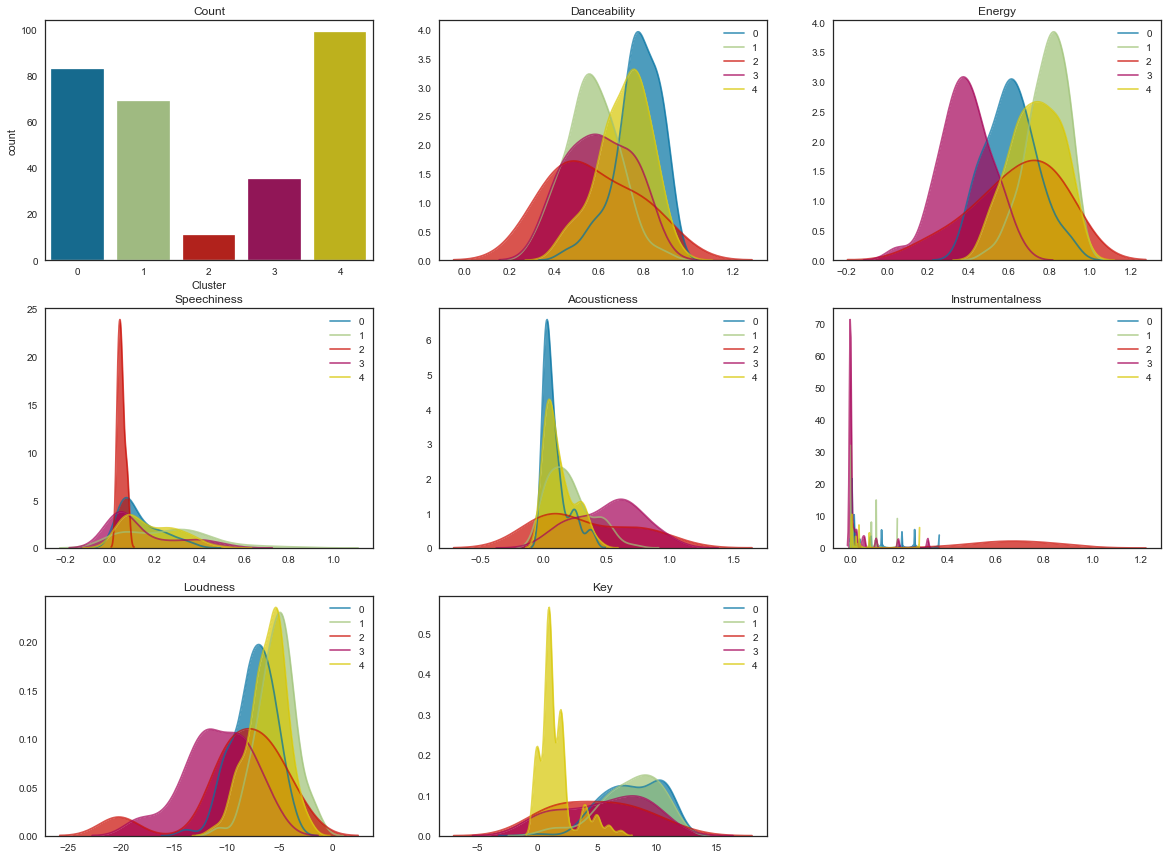

In [56]:
## Set layout of subplots
fig, ax = plt.subplots(3, 3, figsize=(20, 15))

## How many songs per cluster
print(cluster_distrib(df_final, 'Cluster'))
ax[0,0].title.set_text('Count')
sns.countplot(x = df_final['Cluster'], ax = ax[0,0])

## Plot the distributions of the features
ax[0,1].title.set_text('Danceability')
for cluster in np.arange(0,k+1):
    sns.kdeplot(df_final[df_final['Cluster'] == cluster]['danceability'], label = cluster, shade = True, alpha = .7, ax = ax[0,1])

ax[0,2].title.set_text('Energy')
for cluster in np.arange(0,k+1):
    sns.kdeplot(df_final[df_final['Cluster'] == cluster]['energy'], label = cluster, shade = True, alpha = .7, ax = ax[0,2])

ax[1,0].title.set_text('Speechiness')
for cluster in np.arange(0,k+1):
    sns.kdeplot(df_final[df_final['Cluster'] == cluster]['speechiness'], label = cluster, shade = True, alpha = .7, ax = ax[1, 0])

ax[1,1].title.set_text('Acousticness')
for cluster in np.arange(0,k+1):
    sns.kdeplot(df_final[df_final['Cluster'] == cluster]['acousticness'], label = cluster, shade = True, alpha = .7, ax = ax[1,1])

ax[1,2].title.set_text('Instrumentalness')
for cluster in np.arange(0,k+1):
    sns.kdeplot(df_final[df_final['Cluster'] == cluster]['instrumentalness'], label = cluster, shade = True, alpha = .7, ax = ax[1,2])

ax[2,0].title.set_text('Loudness')
for cluster in np.arange(0,k+1):
    sns.kdeplot(df_final[df_final['Cluster'] == cluster]['loudness'], label = cluster, shade = True, alpha = .7, ax = ax[2,0])
    
ax[2,1].title.set_text('Key')
for cluster in np.arange(0,k+1):
    sns.kdeplot(df_final[df_final['Cluster'] == cluster]['key'], label = cluster, shade = True, alpha = .7, ax = ax[2,1])

## Remove extra subplot
fig.delaxes(ax[2,2])
    

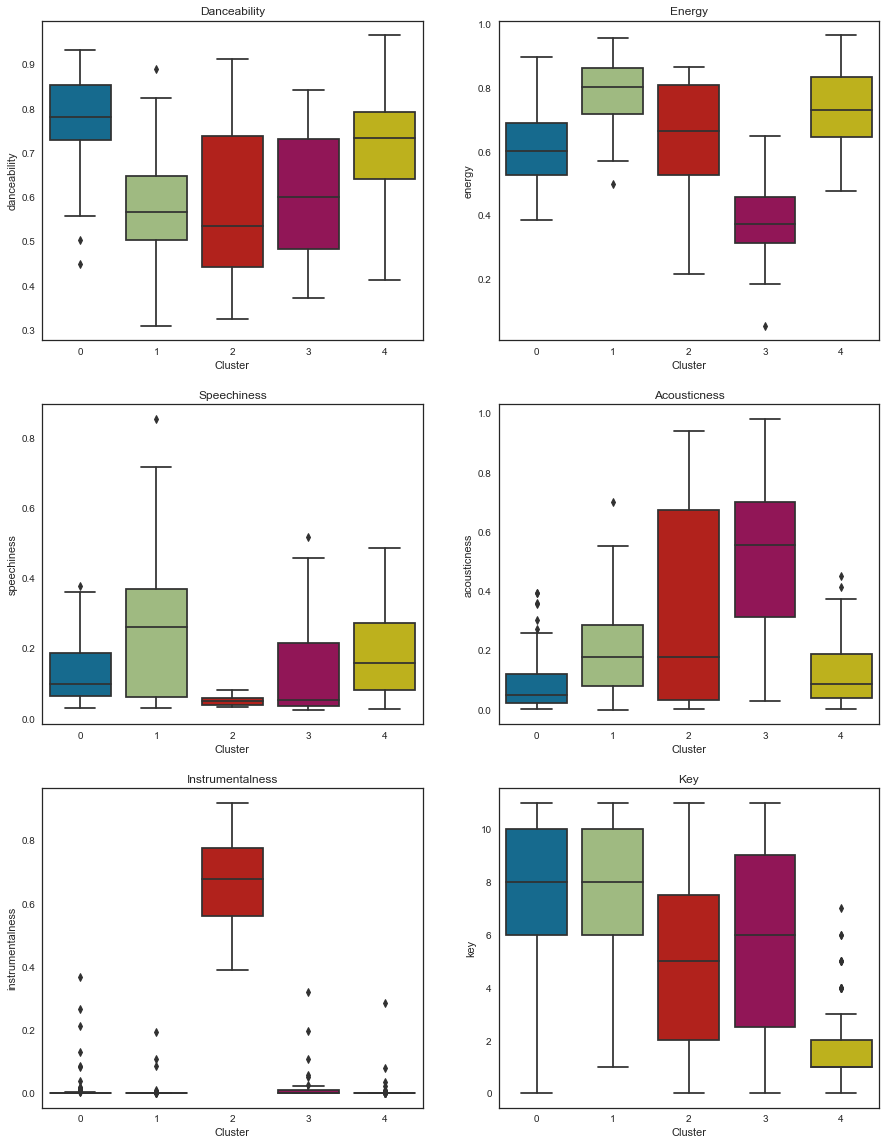

In [57]:
## Set layout of subplots
fig, ax = plt.subplots(3, 2, figsize=(15, 20))


ax[0,0].title.set_text('Danceability')
sns.boxplot(df_final['Cluster'], df_final['danceability'], ax = ax[0,0])

ax[0,1].title.set_text('Energy')
sns.boxplot(df_final['Cluster'], df_final['energy'], ax = ax[0,1])

ax[1,0].title.set_text('Speechiness')
sns.boxplot(df_final['Cluster'], df_final['speechiness'], ax = ax[1,0])

ax[1,1].title.set_text('Acousticness')
sns.boxplot(df_final['Cluster'], df_final['acousticness'], ax = ax[1,1])

ax[2,0].title.set_text('Instrumentalness')
sns.boxplot(df_final['Cluster'], df_final['instrumentalness'], ax = ax[2,0])

ax[2,1].title.set_text('Key')
sns.boxplot(df_final['Cluster'], df_final['key'], ax = ax[2,1])


### Visualize clusters (using PCA)
There are 9 features, but we can only visualize the clusters in up to 2 or 3 dimensions.  Therefore we need to utilize a method to reduce the number of dimensions -- Principal Compenent Analysis

In [58]:
## We'll use 2 components for plotting purposes (x, y axis)
pca = PCA(n_components = 2)

## Apply PC instances to the scaled features.  Create a dataframe 
df_princ_comp = pd.DataFrame(pca.fit_transform(df_scaled_features), columns = ['PC 1', 'PC 2'])
# df_princ_comp = pd.DataFrame(pca.fit_transform(df_scaled_features))

## Add Cluster labels back in 
df_princ_comp = df_princ_comp.join(df_final['Cluster'])

df_princ_comp.head()

,PC 1,PC 2,Cluster
0,-0.49,0.60,1
1,0.68,0.75,1
2,-0.78,-0.42,4
3,-1.66,0.77,1
4,-0.76,-0.73,0


When converting from a higher dimensional space to a lower dimensional space, losing variance (i.e. information) is inevitable.  It is important to review how much variance is explained by the Principal Components being used.  In this case, reducing to two components results in losing a lot of the variance; the two components contain less than half (42.8%) of the original "information"

In [41]:
print(pca.explained_variance_ratio_.sum())
pca.explained_variance_ratio_

0.428078409351692


array([0.26934491, 0.1587335 ])

Create cluster visualization

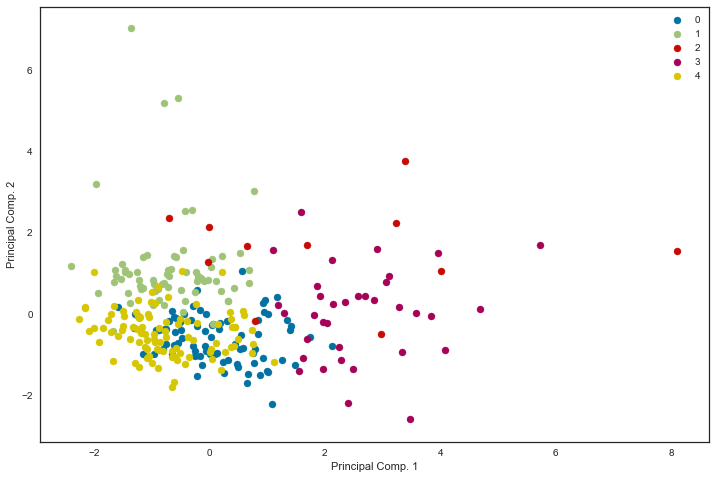

In [59]:
## Set size of plot
plt.figure(figsize = (12, 8))


# colors = ['r', 'g', 'b']
# for target, color in zip(targets,colors):
for cluster in np.arange(0,k):
    
    plt.scatter(df_princ_comp[df_princ_comp['Cluster'] == cluster]['PC 1'],
               df_princ_comp[df_princ_comp['Cluster'] == cluster]['PC 2'], s = 50, label = cluster)

plt.xlabel('Principal Comp. 1')
plt.ylabel('Principal Comp. 2')
plt.legend()
# ax.grid()

To understand how to interpret this plot, we need to understand what each Principal Component represents:

C:\Users\Matt\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


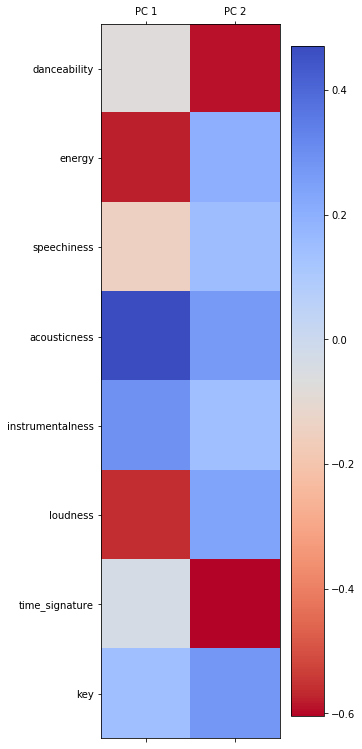

In [78]:
plt.matshow(pca.components_.T,cmap='coolwarm_r')
plt.yticks(range(len(df_final_features.columns[:-1])), df_final_features.columns[:-1], ha='right')

plt.xticks([0,1],['PC 1','PC 2'],fontsize=10)

plt.colorbar()
plt.tight_layout()

### Review most similar / different clusters
Using cosine similarity

In [21]:
## Create dataframe of final cluster assignments with just the features
df_final_features = df_final.drop(['id', 'Song Title', 'Main Artist'], axis = 1)

df_final_features.head()

,danceability,energy,speechiness,acousticness,instrumentalness,loudness,time_signature,key,Cluster
0,0.64,0.77,0.26,0.13,0.00e+00,-6.45,4,11,0
1,0.41,0.60,0.50,0.13,0.00e+00,-10.71,4,7,0
2,0.71,0.80,0.06,0.04,3.77e-03,-7.05,4,4,4
3,0.73,0.70,0.31,0.14,0.00e+00,-5.25,4,6,0
4,0.67,0.90,0.26,0.18,0.00e+00,-3.05,4,8,0


In [51]:
## Create representative vectors for each cluster (each cluster's averagge value per feature)
df_cluster_0 = df_final_features.loc[df_final['Cluster'] == 0, df_final_features.columns[:-1]]
rep_cluster_0 = pd.DataFrame(df_cluster_0.apply(lambda x: x.mean(), axis = 0)).T

df_cluster_1 = df_final_features.loc[df_final['Cluster'] == 1, df_final_features.columns[:-1]]
rep_cluster_1 = pd.DataFrame(df_cluster_1.apply(lambda x: x.mean(), axis = 0)).T

df_cluster_2 = df_final_features.loc[df_final['Cluster'] == 2, df_final_features.columns[:-1]]
rep_cluster_2 = pd.DataFrame(df_cluster_2.apply(lambda x: x.mean(), axis = 0)).T

df_cluster_3 = df_final_features.loc[df_final['Cluster'] == 3, df_final_features.columns[:-1]]
rep_cluster_3 = pd.DataFrame(df_cluster_3.apply(lambda x: x.mean(), axis = 0)).T

df_cluster_4 = df_final_features.loc[df_final['Cluster'] == 4, df_final_features.columns[:-1]]
rep_cluster_4 = pd.DataFrame(df_cluster_4.apply(lambda x: x.mean(), axis = 0)).T

df_cluster_5 = df_final_features.loc[df_final['Cluster'] == 5, df_final_features.columns[:-1]]
rep_cluster_5 = pd.DataFrame(df_cluster_5.apply(lambda x: x.mean(), axis = 0)).T


## Create empty list to store values 
Similiarity_Results = []

## Cluster A
for cluster_a in np.arange(0,k):
    
    ## Cluster B
    for cluster_b in np.arange(cluster_a+1,k):
        

        ## Create representative vectors for each cluster (each cluster's averagge value per feature)
        df_cluster_a = df_final_features.loc[df_final['Cluster'] == cluster_a, df_final_features.columns[:-1]]
        cluster_a_vec = pd.DataFrame(df_cluster_a.apply(lambda x: x.mean(), axis = 0)).T.values.flatten()

        df_cluster_b = df_final_features.loc[df_final['Cluster'] == cluster_b, df_final_features.columns[:-1]]
        cluster_b_vec = pd.DataFrame(df_cluster_b.apply(lambda x: x.mean(), axis = 0)).T.values.flatten()


        ## Calculate similarites for clusters being compared
        sim = cluster_a_vec.dot(cluster_b_vec) / (np.linalg.norm(cluster_a_vec) * np.linalg.norm(cluster_b_vec))

        ## Add Cluster labels and results to list
        Similiarity_Results.append((cluster_a, cluster_b, sim))

In [54]:
# pd.DataFrame(Similiarity_Results, columns=['Cluster A', ' Cluster B', 'Similarity'])
pd.DataFrame(Similiarity_Results, columns=['Cluster A', ' Cluster B', 'Similarity']).sort_values('Similarity', ascending = False)

,Cluster A,Cluster B,Similarity
5,1,2,1.00
4,0,5,0.98
11,2,5,0.96
8,1,5,0.95
2,0,3,0.95
10,2,4,0.94
7,1,4,0.94
13,3,5,0.91
1,0,2,0.90
0,0,1,0.88


Review which songs are assigned to each cluster

In [30]:
cluster_0 = [r['Song Title'] + " | " + r['Main Artist'] for i, r in df_final[df_final['Cluster'] == 0].iterrows()]
cluster_1 = [r['Song Title'] + " | " + r['Main Artist'] for i, r in df_final[df_final['Cluster'] == 1].iterrows()]
cluster_2 = [r['Song Title'] + " | " + r['Main Artist'] for i, r in df_final[df_final['Cluster'] == 2].iterrows()]
cluster_3 = [r['Song Title'] + " | " + r['Main Artist'] for i, r in df_final[df_final['Cluster'] == 3].iterrows()]
cluster_4 = [r['Song Title'] + " | " + r['Main Artist'] for i, r in df_final[df_final['Cluster'] == 4].iterrows()]
cluster_5 = [r['Song Title'] + " | " + r['Main Artist'] for i, r in df_final[df_final['Cluster'] == 5].iterrows()]

pd.set_option("max_rows", None)
df_cluster_results = pd.concat([pd.DataFrame(cluster_0), pd.DataFrame(cluster_1), pd.DataFrame(cluster_2),
                                pd.DataFrame(cluster_3), pd.DataFrame(cluster_4), pd.DataFrame(cluster_5)], ignore_index = True, axis = 1)

## Fill extra rows in shorter columns with empty space
df_cluster_results.fillna('', inplace = True)

df_cluster_results

,0,1,2,3,4,5
0,Grown Up | Danny Brown,Tonight I'll Be Staying Here with You | Liam B...,Shoe Boot | Nathaniel Rateliff & The Night Sweats,Encore | JAY-Z,Roses | The Chainsmokers,Contact (feat. Tyga) | Wiz Khalifa
1,To Zion (feat. Carlos Santana) | Ms. Lauryn Hill,Sanctify | St. Paul & The Broken Bones,Wild | Marian Hill,Stay High | Brittany Howard,Anybody | Burna Boy,Higher Love | Kygo
2,I Ain't Heard Of That | Slim Thug,Pretty Little Fears (feat. J. Cole) | 6LACK,A Moment Apart | ODESZA,Oh No | Mos Def,Whoa | Snoh Aalegra,W (feat. Gunna) | Koffee
3,No Better Love | Young Gunz,Ultralight Beam | Kanye West,Sunset Lover | Petit Biscuit,,Valerie (feat. Amy Winehouse) - Version Revisi...,Bad Bad News | Leon Bridges
4,Having A Party - Live | Nathaniel Rateliff & T...,My God Has A Telephone | The Flying Stars Of B...,Always Alright | Alabama Shakes,,Blood Diamonds | The Game,RITMO (Bad Boys For Life) | Black Eyed Peas
5,What We Do | Freeway,One Time | Marian Hill,Oye Como Va - Album Verision | Santana,,"Down Bad (feat. JID, Bas, J. Cole, EARTHGANG &...",The Box | Roddy Ricch
6,Lucifer | JAY-Z,Differently | Marian Hill,Around The World | Kings of Leon,,You Worry Me | Nathaniel Rateliff & The Night ...,Blanco | J Balvin
7,Shine | Lil Wayne,Hot Boyz | Missy Elliott,Waste A Moment | Kings of Leon,,Can't Take My Eyes Off of You - (I Love You Ba...,Ballin' (with Roddy Ricch) | Mustard
8,Otis | JAY-Z,Apparently | J. Cole,Little Martha | The Allman Brothers Band,,Boasty (feat. Idris Elba) | Wiley,BROWN SKIN GIRL | Blue Ivy
9,RNP (feat. Anderson .Paak) | YBN Cordae,Latch - Acoustic | Sam Smith,Whipping Post | The Allman Brothers Band,,I Just Wanna Love U (Give It 2 Me) | JAY-Z,Toast | Koffee


___
___
# Find most similar/different songs

#### Within my library

#### Compared to another playlist

___
___
# Artists

___
___
# Songs